In [4]:
############################# Importing all req. libreries ############################################
import ipywidgets as ipw
from pymongo import MongoClient
from mongoengine import connect,Document,fields,disconnect
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib
%matplotlib qt
import matplotlib.pyplot as plt
from bson import ObjectId
from IPython.display import display
from IPython.display import Image


############################# Selecting the Entity IDs  ############################################
ids = pd.read_excel("IDs.xlsx")


client = MongoClient("mongodb://localhost:27017")
database = client["SCM_DB"]
connect(db="SCM_DB")
#disconnect()

Mobile_Spec = ipw.Dropdown(
    options=list(ids["MobileSpceIds"]),
    description = "Select Mobile - ", )
Manuf_id = ipw.Dropdown(
    options=list(ids["Manufacturer"].dropna()),
    description = "Manufacturer - ", )
ipw.HBox([Mobile_Spec , Manuf_id])

In [5]:
Manuf_id = Manuf_id.value
Mobile_Spec = Mobile_Spec.value

In [6]:
############################# Printing the Selected Manufacturer  ######################################
collection = database["Top_Level_Assembly_Colleciton"]
cruser = collection.find({"Manufacturer_ID": Manuf_id})
for doc in cruser: 
    doc = doc["Manufacturer locaiton"]
    display(pd.Series(doc,index=doc.keys()))
    break

Manufacturer Name        Neutral Sarun GmbH
Manufacturer Address     Kurt-Leucht-Weg 11
Manufacturer City                   Numberg
Manufacturer Country                Germany
Manufacturer ZIP Code                 90471
dtype: object

_id                                              5e4acd2b430f6652feafa93d
Mobile_Name                                            Samsung_galaxy_A71
Mobile_Type                                                        Galaxy
network_technology                                   [GSM ,  HSPA ,  LTE]
2G_bands                [GSM 850 , GSM  900 , GSM  1800 , GSM  1900 - ...
3G_bands                [HSDPA 850 , HSDPA  900 , HSDPA  1900 , HSDPA ...
4G_bands                [LTE band 1(2100), LTE band  3(1800), LTE band...
network_speed           [ "HSPA 42.2/5.76 Mbps","  LTE Cat4 150/50 Mbps"]
GPRS                                                                 True
EDGE                                                                 True
announced                                             2017-06-01 00:00:00
status                             Coming soon. Exp. release 2017  August
SIM                     Single SIM (Nano-SIM) or Dual SIM (Nano-SIM| d...
display_type              Super AMOLED

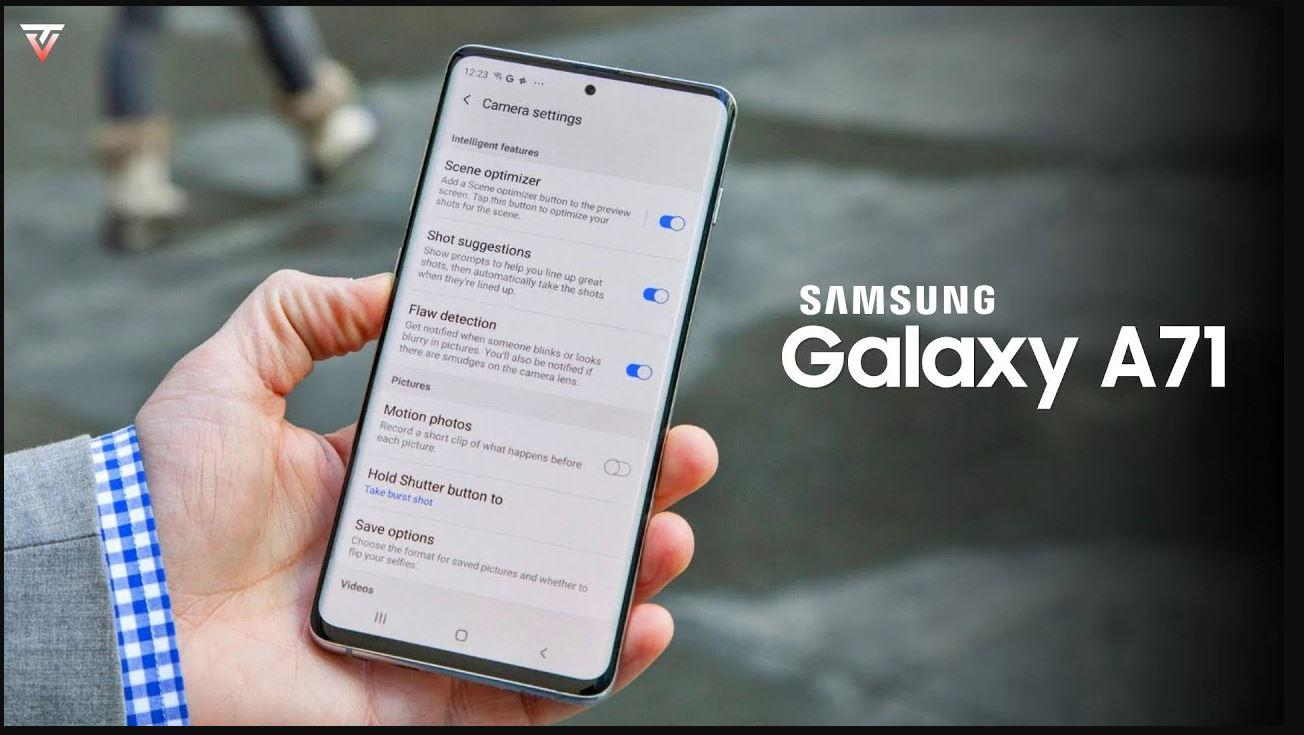

In [7]:
############################# Printing the Selected Mobile Specifications  ##############################
collection = database["Mobile_Specifications"]
cruser = collection.find({"_id": ObjectId(Mobile_Spec)})
for doc in cruser: 
    display(pd.Series(doc,index=doc.keys()))
    break
    
collection = database["Mobile_Images"]
cruser = collection.find({"mob_ds_id": ObjectId(Mobile_Spec)})
for doc in cruser: 
    class mobile(Document):
        meta = {"collection" : "Mobile_Images"}
        mob_ds_id= fields.ObjectIdField(requried=True)
        mob_name = fields.StringField(requried=True)
        image = fields.ImageField(thumbnail_size=(150,150,False))
    mob = mobile.objects(mob_ds_id = doc["mob_ds_id"]).first()
    display(Image(mob.image.read()))
    break

In [10]:
########################################## Mongo DB  #####################################################
collection = database["Retailer_orders_DB"]
pipeline_1 = [
    {
        u"$unwind": {
            u"path": u"$Order_Items_List"
        }
    }, 
    {
        u"$project": {
            u"_id": 0.0,
            u"End_User_ID": u"$End_User_ID",
            u"Mobile IMEI": u"$Order_Items_List",
            u"End User Address": u"$End User Address"
        }
    }, 
    {
        u"$out": u"temp"
    }
]

cursor = collection.aggregate(
    pipeline_1, 
    allowDiskUse = False
)
print("Temp Collection Created")

Temp Collection Created


In [11]:
collection = database["Top_Level_Assembly_Colleciton"]
pipeline_2 = [
    {
        u"$match": {
            u"Manufacturer_ID": Manuf_id,
            u"Mobile Spec Reference": Mobile_Spec
        }
    }, 
    {
        u"$project": {
            u"_id": 0.0,
            u"Mobile IMEI": u"$Mobile IMEI"
        }
    }, 
    {
        u"$lookup": {
            u"from": u"temp",
            u"localField": u"Mobile IMEI",
            u"foreignField": u"Mobile IMEI",
            u"as": u"k"
        }
    }, 
    {
        u"$unwind": {
            u"path": u"$k"
        }
    }, 
    {
        u"$project": {
            u"End_User_ID": u"$k.End_User_ID",
            u"End User Address": u"$k.End User Address"
        }
    }, 
    {
        u"$lookup": {
            u"from": u"Geolocations",
            u"localField": u"End User Address",
            u"foreignField": u"Address",
            u"as": u"Geolocation"
        }
    }, 
    {
        u"$unwind": {
            u"path": u"$Geolocation"
        }
    }, 
    {
        u"$project": {
            u"User_ID": u"$End_User_ID",
            u"Latitude": u"$Geolocation.Latitude",
            u"Longitude": u"$Geolocation.Longitude"
        }
    }
]
cursor = collection.aggregate(
    pipeline_2, 
    allowDiskUse = False
)
lats = []
lons = []
try:
    for doc in cursor:
        print(doc)
        lats.append(doc["Latitude"])
        lons.append(doc["Longitude"])
finally:
    client.close()


{'User_ID': 'User_US_400', 'Latitude': 33.6505, 'Longitude': -83.7116}
{'User_ID': 'User_US_062', 'Latitude': 46.6873, 'Longitude': -119.9311}
{'User_ID': 'User_GER_599', 'Latitude': 49.246864, 'Longitude': 7.369766}
{'User_ID': 'User_US_069', 'Latitude': 48.694951, 'Longitude': 10.779154}
{'User_ID': 'User_US_336', 'Latitude': 43.363223, 'Longitude': -5.853128}
{'User_ID': 'User_SP_616', 'Latitude': 48.62958, 'Longitude': 12.497606}
{'User_ID': 'User_GER_423', 'Latitude': 53.469193, 'Longitude': 7.482319}
{'User_ID': 'User_SP_406', 'Latitude': 40.1538, 'Longitude': -79.7424}
{'User_ID': 'User_SP_591', 'Latitude': 61.5416, 'Longitude': -160.3337}
{'User_ID': 'User_US_660', 'Latitude': 50.40718, 'Longitude': 7.14789}


In [12]:
####################### Visulizing the results in Map ###################################################
m = Basemap(projection='mill',
                resolution='l') 

m.drawcoastlines()
m.drawcountries(linewidth=0.1)

for lat , lon in zip(lats,lons):
    x,y = m.projtran(lon,lat)
    m.plot(x,y,'c*',markersize=15)
plt.show()

C:\Users\anilk\Anaconda3\envs\Final\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\anilk\Anaconda3\envs\Final\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
